In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import sagemaker

In [2]:
data_dir = 'input_data'
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
data_s3_prefix = 'santander_project/data'

In [ ]:
# Reading in training data
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'), index_col='ID')

## Manual Feature Selection

Examing correlation between features and the target using a Spearman coefficient. Spearman's rank-order was chosen because of the extreme range of values in the target data

In [3]:
if os.path.exists(os.path.join(data_dir, 'correlation_matrix.csv')):
    correlation_matrix = pd.read_csv(os.path.join(data_dir, 'correlation_matrix.csv'), header=None, index_col=0, squeeze=True)
else:
    correlation_matrix = train_df.corr(method='spearman')['target'][1:]
    correlation_matrix.to_csv(os.path.join(data_dir, 'correlation_matrix.csv'), header=False)

Now visualizing the distribution of feature correlations

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(range(len(correlation_matrix)), np.sort(correlation_matrix.values))

.05 appears to be a good cutoff for reducing features based on target correlation.

In [4]:
spearman_threshold = .05
correlated_features = correlation_matrix[abs(correlation_matrix) > spearman_threshold].sort_values(ascending=False)
train_df_reduced = pd.concat([train_df.target, train_df[list(correlated_features.index)]], axis=1)

Features have been reduced to only those with an absolute Spearman correlation value of over .1. Now, examining correlation of features with one another, and removing those that have a high Spearman correlation to one another.

In [ ]:
feature_matrix = train_df_reduced.iloc[:, 1:].corr(method='spearman').abs()

Text(0.5, 1, 'Feature Correlation Matrix')

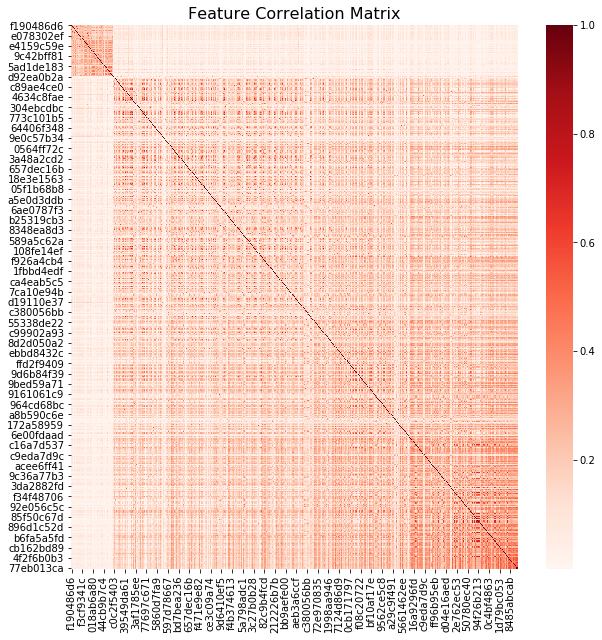

In [5]:
plt.figure(figsize=(10,10))
sns.heatmap(feature_matrix, cmap='Reds').set_title('Feature Correlation Matrix', fontsize=16)

In [6]:
#Removing correlated features
columns = np.full((feature_matrix.shape[0],), True, dtype=bool)

for i in range(feature_matrix.shape[0]):
    for j in range(i+1, feature_matrix.shape[0]):
        if feature_matrix.iloc[i,j] >= 0.5:
            if columns[j]:
                columns[j] = False
                
selected_columns = train_df_reduced.iloc[:, 1:].columns[columns]
train_df_reduced = pd.concat((train_df_reduced['target'], train_df_reduced[selected_columns]), axis=1)

Features have been further reduced based on their Spearman correlation to one another. Now applying transforms.

## Feature and Target Data Transformations

Based on results in EDA, i opt to normalize the target using a Box-Cox method, and the features using a log transform.

In [7]:
transform_method = 'log'

def train_transform(df, method=None):
    transformer = None
    df['target'] = stats.boxcox(df['target'])[0]
    if method == 'log':
        log_vals = np.log(df.iloc[:, 1:].mask(df <=0)).fillna(0).values
        df.iloc[:, 1:] = log_vals
        return df, transformer
    elif method == 'yeo-johnson':
        transformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
        transformer.fit(df.iloc[:, 1:].values)
        yeo_vals = transformer.transform(df.iloc[:, 1:].values)
        df.iloc[:, 1:] = yeo_vals
        return df, transformer
    elif method == 'square_root':
        squares = np.sqrt(df.iloc[:, 1:].values)
        df.iloc[:, 1:] = squares
        return df, transformer
    elif method == 'cube_root':
        cubes = np.cbrt(df.iloc[:, 1:].values)
        df.iloc[:, 1:] = cubes
        return df, transformer
    elif method == 'reciprocal':
        inverse = np.reciprocal(df.iloc[:, 1:].mask(df <=0)).fillna(0).values
        df.iloc[:, 1:] = inverse
        return df, transformer
    else:
        print('Invalid Transformation - Dataframe Not Processed')
        return df, transformer
        


In [8]:
train_df_reduced, transformer = train_transform(train_df_reduced, transform_method)

In [9]:
#Saving to local drive
train_df_reduced.to_csv(os.path.join(data_dir, 'train_reduced.csv'), header=False, index=False)

I will apply the same steps to the test dataset here:

In [10]:
#Specifying columns to be used, then reading in reduced dataset
cols_to_use = list(train_df_reduced.reset_index().drop('target', axis=1).columns)

test_df_reduced = pd.read_csv(os.path.join(data_dir, 'test.csv'), index_col='ID', header=0, usecols=cols_to_use)


In [11]:
#Transforming test dataset, applying same method as that to training data

def test_transform(df, method=None):
    if method == 'log':
        log_vals = np.log(df.iloc[:, :].mask(df <= 0)).fillna(0).values
        df.iloc[:, :] = log_vals
        return df
    elif method == 'yeo-johnson':
        global transformer
        yeo_vals = transformer.transform(df.values)
        df.iloc[:, :] = yeo_vals
        return df
    elif method == 'square_root':
        squares = np.sqrt(df.values)
        df.iloc[:, :] = squares
        return df
    elif method == 'cube_root':
        cubes = np.cbrt(df.values)
        df.iloc[:, :] = cubes
        return df
    elif method == 'recpiprocal':
        inverse = np.reciprocal(df.mask(df <=0)).fillna(0).values
        df.iloc[:, :] = inverse
        return df
    
    else:
        print('Invalid Transformation - Dataframe Not Processed')
        return df

In [13]:
test_transform(test_df_reduced, method=transform_method)

48df886f9  11d86fa6a  0d866c3d7  d04e16aed  ea18d720e  b4ced4b7a  \
ID                                                                            
000137c73        0.0        0.0        0.0        0.0        0.0   0.000000   
00021489f        0.0        0.0        0.0        0.0        0.0   0.000000   
0004d7953        0.0        0.0        0.0        0.0        0.0   0.000000   
00056a333        0.0        0.0        0.0        0.0        0.0   0.000000   
00056d8eb        0.0        0.0        0.0        0.0        0.0   0.000000   
...              ...        ...        ...        ...        ...        ...   
fff73b677        0.0        0.0        0.0        0.0        0.0  13.015789   
fff7b5923        0.0        0.0        0.0        0.0        0.0   0.000000   
fff7c698f        0.0        0.0        0.0        0.0        0.0   0.000000   
fff8dba89        0.0        0.0        0.0        0.0        0.0   0.000000   
fffbe2f6f        0.0        0.0        0.0        0.0        0.0   0.000000   

           c16a7d537  92e056c5c  e0f6a993a  42fdff3a0  ...  f7f553aea  \
ID                                                     ...              
000137c73        0.0   0.000000        0.0        0.0  ...        0.0   
00021489f        0.0   0.000000        0.0        0.0  ...        0.0   
0004d7953        0.0   0.000000        0.0        0.0  ...        0.0   
00056a333        0.0   0.000000        0.0        0.0  ...        0.0   
00056d8eb        0.0   0.000000        0.0        0.0  ...        0.0   
...              ...        ...        ...        ...  ...        ...   
fff73b677        0.0   0.000000        0.0        0.0  ...        0.0   
fff7b5923        0.0   0.000000        0.0        0.0  ...        0.0   
fff7c698f        0.0  14.314857        0.0        0.0  ...        0.0   
fff8dba89        0.0   0.000000        0.0        0.0  ...        0.0   
fffbe2f6f        0.0   0.000000        0.0        0.0  ...        0.0   

           56ec098a1  ed5af35f0  e43343256  108fe14ef  a19b05919  b625fe55a  \
ID                                                                            
000137c73        0.0        0.0        0.0        0.0        0.0        0.0   
00021489f        0.0        0.0        0.0        0.0        0.0        0.0   
0004d7953        0.0        0.0        0.0        0.0        0.0        0.0   
00056a333        0.0        0.0        0.0        0.0        0.0        0.0   
00056d8eb        0.0        0.0        0.0        0.0        0.0        0.0   
...              ...        ...        ...        ...        ...        ...   
fff73b677        0.0        0.0        0.0        0.0        0.0        0.0   
fff7b5923        0.0        0.0        0.0        0.0        0.0        0.0   
fff7c698f        0.0        0.0        0.0        0.0        0.0        0.0   
fff8dba89        0.0        0.0        0.0        0.0        0.0        0.0   
fffbe2f6f        0.0        0.0        0.0        0.0        0.0        0.0   

           31e434a58  e431708ff  85dcc913d  
ID                                          
000137c73        0.0        0.0        0.0  
00021489f        0.0        0.0        0.0  
0004d7953        0.0        0.0        0.0  
00056a333        0.0        0.0        0.0  
00056d8eb        0.0        0.0        0.0  
...              ...        ...        ...  
fff73b677        0.0        0.0        0.0  
fff7b5923        0.0        0.0        0.0  
fff7c698f        0.0        0.0        0.0  
fff8dba89        0.0        0.0        0.0  
fffbe2f6f        0.0        0.0        0.0  

[49342 rows x 348 columns]

Saving files to local drive and s3

In [ ]:
test_df_reduced.to_csv(os.path.join(data_dir, 'test_reduced.csv'), header=False, index=False)
sagemaker_session.upload_data(path=os.path.join(data_dir, 'test_reduced.csv'), bucket=bucket, key_prefix=data_s3_prefix)